In [1]:
# The code refers from segment anything project https://github.com/facebookresearch/segment-anything

# Object masks from prompts with MobileSAM

The Mobile Segment Anything Model (MobileSAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/opengeos/segment-anything/blob/pypi/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

In [3]:
import sys

In [4]:
if 'google.colab' in sys.modules:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install git+https://github.com/ChaoningZhang/MobileSAM.git
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture2.jpg
        
    !wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt


If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. 

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [7]:
# image = cv2.imread('images/picture1.jpg')
image = cv2.imread('/Users/eliaweiss/Documents/doc2txt/sihach/attachments/20231025012642_001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

(-0.5, 1705.5, 1200.5, -0.5)

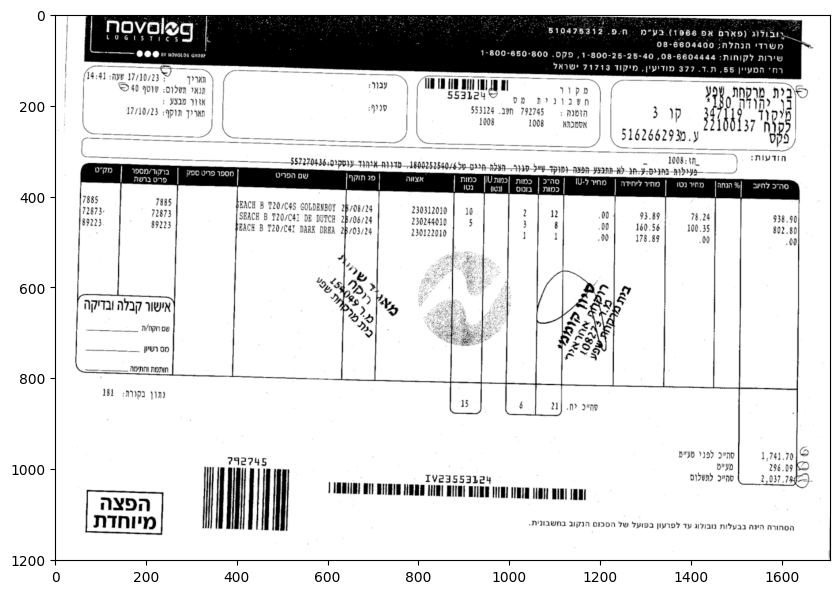

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
# plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [9]:
import sys
sys.path.append("..")
from mobile_sam import sam_model_registry, SamPredictor

sam_checkpoint = "../weights/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

predictor = SamPredictor(sam)

/Users/eliaweiss/ai/MobileSAM/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/MobileSAM/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/MobileSAM/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaw

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [10]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [11]:
input_point = np.array([[205, 189]])
# input_point = np.array([[450, 350]])
input_label = np.array([1])

In [12]:
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [13]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [14]:
masks.shape  # (number_of_masks) x H x W

(3, 1201, 1706)

In [15]:
image.shape

(1201, 1706, 3)

In [23]:
def format_results(masks, scores, logits, filter=0):
    annotations = []
    n = len(scores)
    for i in range(n):
        annotation = {}

        mask = masks[i]
        tmp = np.where(mask != 0)
        if np.sum(mask) < filter:
            continue
        annotation["id"] = i
        annotation["segmentation"] = mask
        annotation["bbox"] = [
            np.min(tmp[0]),
            np.min(tmp[1]),
            np.max(tmp[1]),
            np.max(tmp[0]),
        ]
        annotation["score"] = scores[i]
        annotation["area"] = annotation["segmentation"].sum()
        annotations.append(annotation)
        break
    return annotations

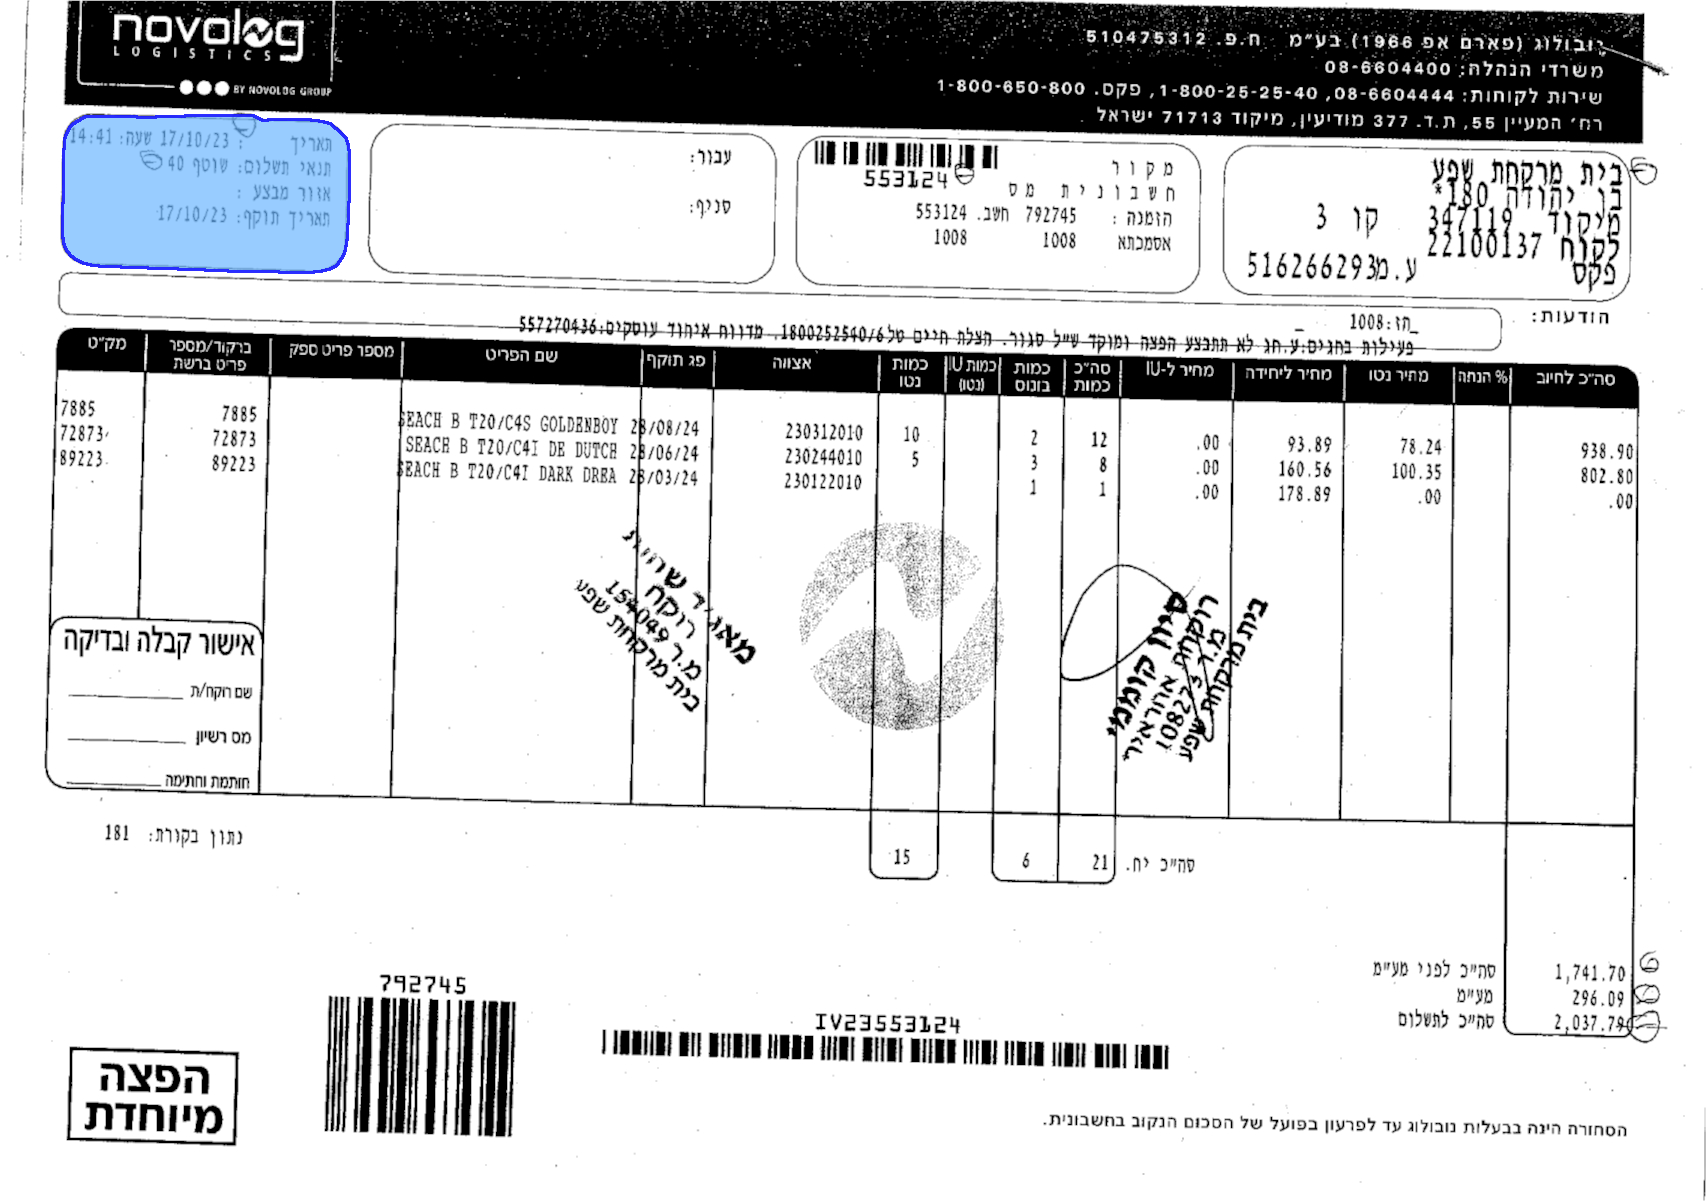

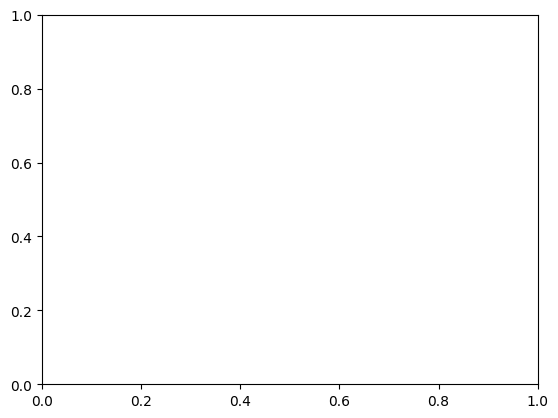

In [22]:

from app.utils.tools import point_prompt
from app.utils.tools_gradio import fast_process
from PIL import Image

h, w = image.shape[0:2]
results = format_results(masks, scores, logits, 0)

annotations, _ = point_prompt(
    results, input_point, input_label, h, w
)
annotations = np.array([annotations])

input_size = 1024
better_quality=False,
withContours=True,
use_retina=True,
mask_random_color=True,
image_pil = Image.fromarray(image)
fig = fast_process(
    annotations=annotations,
    image=image_pil,
    device=device,
    scale=(1024 // input_size),
    better_quality=better_quality,
    mask_random_color=mask_random_color,
    bbox=None,
    use_retina=use_retina,
    withContours=withContours,
)
fig 


# working example

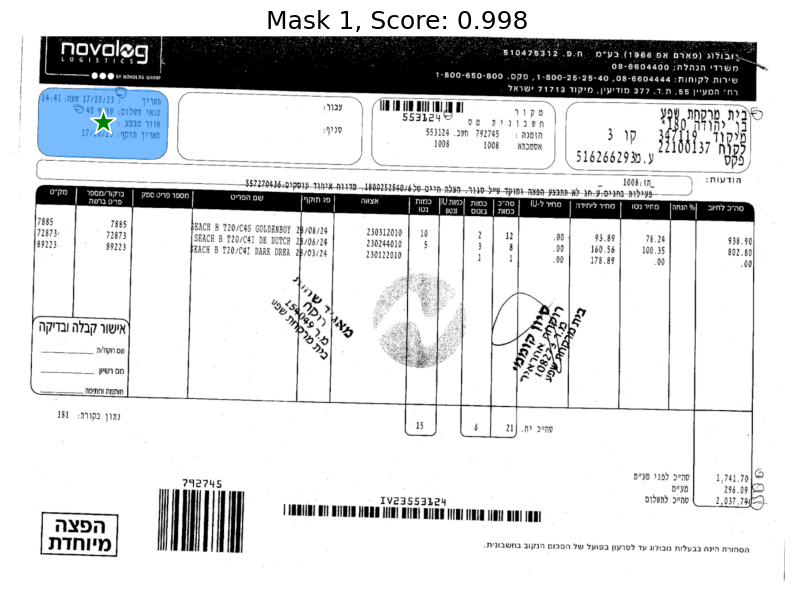

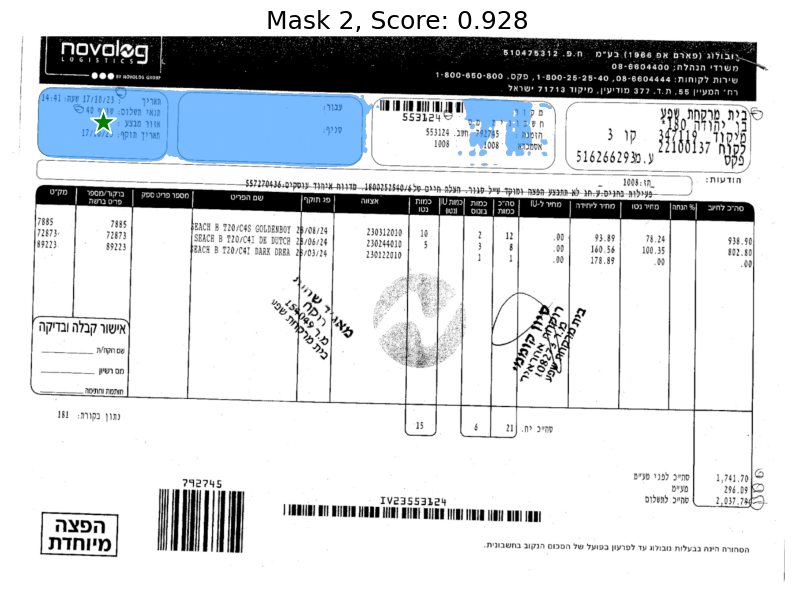

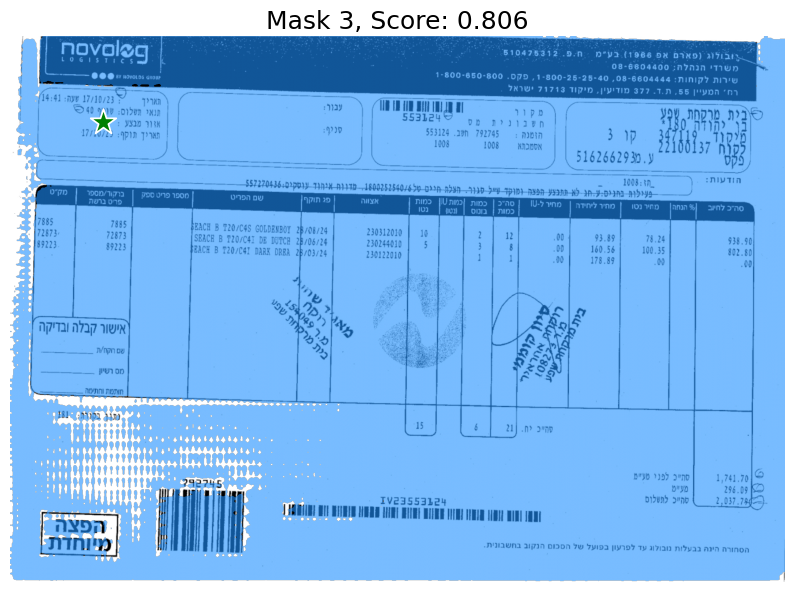

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
    # break
  